Ниже представлена работа по предварительной подготовке и очистке данных для проведения регрессионного анализа. Регрессионный анализ посвящен поиску взаимосвязи между эффективностью медицинской политики в борьбе с коронавирусом и голосованием за партию «Единая Россия» на парламентских выборах в 2021 году. Сам регрессионный анализ был проведен в r-studio, так как в нем больше возможностей для обработки статистических данных.

Эффективность медицинской политики оценивается на основе 100-балльной шкалы. Рассчет предполагает нормировку всех показателей в индексы, измеряющиеся от 0 до 100 баллов по формуле.

**Index = 100 * ((x - min) / (max - min))**

**x** -  значение показателя для конкретного региона РФ

**max** - максимальное значение показателя по выборке из 85 регионов

**min** - минимальное значение показателя по вборке из 85 регионов

Формулы для рассчета были взяты из [исследования](https://www.hse.ru/news/381045220.html) Института муниципального и государственного управления НИУ ВШЭ.

**Рейтинг по медицине =  (0.25) * Мощность системы здравоохранения + (0.25) * Случае инфицирования на 100 тыс. + (0.25) * Максимум новых случаев за 30 дней на 100 тыс. + (0.25) * Смертей от COVID-19 на 100 тыс.**

Мощность системы здравоохранения рассчитывается по формуле ниже.


**Мощность системы здравоохранения = (0.4) * Количество врачей на 100 тыс. + (0.3) * Количество среднего медицинского персонала + (0.3) * Количество больничных коек на 100 тыс.**

In [519]:
import pandas as pd
from functools import reduce
import seaborn as sns
import requests
from bs4 import BeautifulSoup

from sklearn.linear_model import LinearRegression
import numpy as np

**Население субъектов РФ**

Сначала мы добавим в наш датасет информацию о населении субъектов РФ, чтобы затем нормировать все остальные показатели к 100 000 человек. Проще всего спарсить информацию из википедии.

In [469]:
website_url = requests.get('https://ru.wikipedia.org/wiki/%D0%9D%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D1%83%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B9%D1%81%D0%BA%D0%BE%D0%B9_%D0%A4%D0%B5%D0%B4%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D0%B8').text
soup = BeautifulSoup(website_url,'lxml')

My_table = soup.find('table',{'class':'standard sortable'})
pop=pd.read_html(str(My_table))
# convert list to dataframe
pop=pd.DataFrame(pop[0])

In [470]:
pop = pop[['Субъект РФ','Всёнаселе-ние, чел']]
pop.columns = ['region','population']
pop['population'] = pop['population'].apply(lambda x: x[1:])
pop['population'] = pop['population'].apply(lambda x: int(''.join(x.split())))
pop=pop.set_index('region').drop(['Тюменская область(с ХМАО и ЯНАО)', 'РФ','Архангельская область (с НАО)']).reset_index()

Заранее приводим название субъектов к единообразному виду, чтобы было проще затем склеивать датафреймы друг с другом.

In [471]:
def change_name3(x):

    if 'область' in x:
        return x.replace('область','обл.').strip()
    
    elif 'Республика' in x:
        return x.replace('Республика', '').strip()
    
    elif 'автономный округ' in x:
        return x.replace('автономный округ','АО').strip()
    
    else:
        return x
    
    

In [472]:
def change_name2(x):
    
    if 'Кабардино-Балкарская Республика' in x:
        return x.replace('Кабардино-Балкарская Республика','Кабардино-Балкария')
    
    elif 'Архангельская область без НАО' in x:
        return x.replace('Архангельская область без НАО', 'Архангельская обл.')
    
    elif 'Ханты-Мансийскийавтономный округ — Югра' in x:
        return x.replace('Ханты-Мансийскийавтономный округ — Югра', 'ХМАО – Югра')
    
    elif 'Севастополь[a]' in x:
        return x.replace('Севастополь[a]', 'Севастополь')
    
    else:
        return x

In [473]:
def change_name1(x):
    if 'Республика Крым[a]' in x:
        return x.replace('Республика Крым[a]','Крым')
    
    elif 'Республика СевернаяОсетия — Алания' in x:
        return x.replace('Республика СевернаяОсетия — Алания','Северная Осетия')
    
    elif 'Тюменская областьбез ХМАО и ЯНАО' in x:
        return x.replace('Тюменская областьбез ХМАО и ЯНАО','Тюменская обл.')
    
    elif 'Чеченская Республика' in x:
        return x.replace('Чеченская Республика', 'Чечня')
    
    elif 'Чувашская Республика' in x:
        return x.replace('Чувашская Республика','Чувашия')
    
    elif 'Карачаево-Черкесская Республика' in x:
        return x.replace('Карачаево-Черкесская Республика','Карачаево-Черкессия')
    
    elif 'Удмуртская Республика' in x:
        return x.replace('Удмуртская Республика','Удмуртия')
    
    elif 'Еврейская автономная область':
        return x.replace('Еврейская автономная область', 'Еврейская АО')
    
    elif 'Карачаево-Черкесская' in x:
        return x.replace('Карачаево-Черкесская','Карачаево-Черкессия')
    
    elif 'Чеченская Республика' in x:
        return x.replace('Чеченская Республика','Чечня')
    
    else:
        return x

In [474]:
pop['region'] = pop['region'].apply(change_name1)
pop['region'] = pop['region'].apply(change_name2)
pop['region'] = pop['region'].apply(change_name3)

**Количество коек**

Загрузим информацию об общем количестве койек в каждом регионе России. Данные были взяты из Росстата.

In [475]:
koiki = pd.read_excel("C:/Users/Asus/data covid/koiki.xls", header = None,)\
          .rename(columns={0:'region',1:'total_koiki'})


In [476]:
l = ['Центральный федеральный округ', 'Южный федеральный  округ ', 'Уральский федеральный округ','Дальневосточный федеральный округ',
    'Северо-Кавказский федеральный округ','Приволжский федеральный округ','Сибирский федеральный округ', 'Северо-Западный федеральный округ',
     'Архангельская область','Тюменская область','Северо-Кавказский','Южный федеральный округ']
koiki = koiki.query('region not in @l')
koiki['region'] = koiki['region'].apply(lambda x: x.strip())



**Количество врачей**

Делаем то же самое для врачей и среднего медицинского персонала.

In [477]:
doctors = pd.read_excel("C:/Users/Asus/data covid/doctors.xlsx")
doctors = doctors.query('region not in @l')
doctors['region'] = doctors['region'].apply(lambda x: x.strip())

**Количество медицинского персонала**

In [478]:
staff = pd.read_excel("C:/Users/Asus/data covid/staff.xlsx")
staff = staff.query('region not in @l')
staff['region'] = staff['region'].apply(lambda x: x.strip())


**Количество случаев заражений на 100 тыс.**

Добавляем информацию об общем числе зараженных на 100 тыс. человек в каждом регионе на момент голосования 19 сентября 2021 года. Данные взяты из агрегированного датасета от Яндекса. Из этого же источника были взяты данные про общую смертность, максимум заражений в течение 30 дней перед выборами.

In [479]:
total_cases_per_100 = pd.read_csv("C:/Users/Asus/data covid/total_cases_per_100.csv", sep = ';')

In [480]:
total_cases_per_100['DateTime'] = pd.to_datetime(total_cases_per_100['DateTime'])

total_infected = total_cases_per_100.set_index('DateTime')\
                                    .loc[:'2021-09-20']\
                                    .T.iloc[:,-1]\
                                    .to_frame()\
                                    .reset_index()

total_infected.columns = ['region','cases_100']



**Общая смертность**

In [481]:
death_covid = pd.read_csv("C:/Users/Asus/data covid/death_covid.csv", sep = ';')

In [482]:
death_covid['DateTime'] = pd.to_datetime(death_covid['DateTime'])

death = death_covid.set_index('DateTime')\
                            .loc[:'2021-09-20']\
                            .T.iloc[:,-1]\
                            .to_frame().reset_index()

death.columns = ['region','death_per_100']

**Прирост максимальный за 30 дней**

In [483]:
prirost = pd.read_csv("C:/Users/Asus/data covid/prirost.csv", sep = ';')

In [484]:
prirost['DateTime'] = pd.to_datetime(prirost['DateTime'])
prirost_max_30 = prirost.set_index('DateTime').loc['2021-08-20':'2021-09-20'].T

prirost_max_30 = prirost_max_30.max(axis=1)\
                               .to_frame()\
                               .reset_index().rename(columns=({'index':'region',0:'max_30_days'}))

prirost_max_30['region'] = prirost_max_30['region'].apply(lambda x: x.strip())

**Избыточная смертность**

Есть предположения о том, что российские власти сознательно манипулировали статистикой о коронавирусе, особенно в аспекте общего числа смертей. Ниже представлен словарь, где ключом является предполагаемое истинное число смертей от ковида. На основе 10 предыдущих лет было посчитано ожидаемая убыль населения, затем она была сопоставлена с фактической убылью населения на сентябрь 2021 года. Отклонение от ожидаемого значения является предположительной истинной оценкой числа смертей от коронавируса.

In [485]:
death_real = {'Адыгея': 1700, 'Алтай': 807, 'Алтайский край': 13164, 'Амурская обл.': 4079, 'Архангельская обл.': 4890,
 'Астраханская обл.': 5135,'Башкортостан': 22099, 'Белгородская обл.': 7662, 'Брянская обл.': 5865, 'Бурятия': 3350,
 'Владимирская обл.': 7448, 'Волгоградская обл.': 15794, 'Вологодская обл.': 4144,'Воронежская обл.': 12957, 'Дагестан': 8031,
 'Еврейская АО': 652,'Забайкальский край': 3544,'Ивановская обл.': 4277,'Ингушетия': 1005,'Иркутская обл.': 10981,'Кабардино-Балкария': 2816,
 'Калининградская обл.': 3832,'Калмыкия': 1154, 'Калужская обл.': 5658,'Камчатский край': 1312,'Карачаево-Черкессия': 1701,
 'Карелия': 3510,'Кемеровская обл.': 11818,'Кировская обл.': 6752,'Коми': 3241,'Костромская обл.': 2984,'Краснодарский край': 32515,
 'Красноярский край': 13581,'Крым': 9082, 'Курганская обл.': 4355,'Курская обл.': 6443,'Ленинградская обл.': 10430, 'Липецкая обл.': 8349,
 'Магаданская обл.': 479,'Марий Эл': 3156,'Мордовия': 4815,'Москва': 70415,'Московская обл.': 42967,'Мурманская обл.': 3773,
 'Ненецкий АО': 187,'Нижегородская обл.': 17789, 'Новгородская обл.': 2901,'Новосибирская обл.': 15631,'Омская обл.': 10734,
 'Оренбургская обл.': 13784,'Орловская обл.': 3690,'Пензенская обл.': 8472, 'Пермский край': 11855, 'Приморский край': 8131,
'Псковская обл.': 2531, 'Ростовская обл.': 23338,'Рязанская обл.': 7548, 'Самарская обл.': 19796,'Санкт-Петербург': 31733,
 'Саратовская обл.': 16289,'Саха (Якутия)': 3314,'Сахалинская обл.': 1760,
 'Свердловская обл.': 21966,'Севастополь': 1914, 'Северная Осетия': 2857,'Смоленская обл.': 3968, 'Ставропольский край': 12089,
 'Тамбовская обл.': 5237, 'Татарстан': 22588, 'Тверская обл.': 5349, 'Томская обл.': 5054, 'Тульская обл.': 7022, 'Тыва': 424,
 'Тюменская обл.': 6446, 'Удмуртия': 6925, 'Ульяновская обл.': 7190, 'Хабаровский край': 6045, 'Хакасия': 1838, 'ХМАО – Югра': 1222,
 'Челябинская обл.': 18958, 'Чечня': 4303, 'Чувашия': 7164,'Чукотский АО': 116,'Ямало-Ненецкий АО': 1222, 'Ярославская обл.': 6694}

In [486]:
death_real = pd.DataFrame(death_real.items())
death_real = death_real.rename(columns={0:'region',1:'death_real'})

**Добавляем результаты голосования**

Теперь нам нужны результаты голосования за партию власти в разрезе регионов — парсим информацию из википедии. 

In [487]:
website_url = requests.get('https://ru.wikipedia.org/wiki/%D0%92%D1%8B%D0%B1%D0%BE%D1%80%D1%8B_%D0%B2_%D0%93%D0%BE%D1%81%D1%83%D0%B4%D0%B0%D1%80%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D1%83%D1%8E_%D0%B4%D1%83%D0%BC%D1%83_(2021):_%D1%80%D0%B5%D0%B7%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D1%82%D1%8B_%D0%BF%D0%BE_%D0%BF%D0%B0%D1%80%D1%82%D0%B8%D0%B9%D0%BD%D1%8B%D0%BC_%D1%81%D0%BF%D0%B8%D1%81%D0%BA%D0%B0%D0%BC').text
soup = BeautifulSoup(website_url,'lxml')


My_table = soup.find_all('table',{'class':"wikitable sortable"})
df=pd.read_html(str(My_table))

In [488]:
voting = pd.DataFrame(df[2]).droplevel(level=[0,1],axis=1)\
                            .iloc[:,:4]\
                            .rename(columns={'Наименование':'region', 'Явка':'turnout','ЕР':'UR','КПРФ':'CPRF'})

Приводим названия регинов к единообразному виду.

In [489]:
def change_name4(x):
    if 'Кабардино-Балкарская Респ.' in x:
        return x.replace('Кабардино-Балкарская Респ.','Кабардино-Балкария')
    elif 'Карачаево-Черкесская Респ.' in x:
        return x.replace('Карачаево-Черкесская Респ.', 'Карачаево-Черкессия')
    elif 'Сев. Осетия' in x:
        return x.replace('Сев. Осетия', 'Северная Осетия')
    elif 'Ханты-Мансийский АО' in x:
        return x.replace('Ханты-Мансийский АО','ХМАО – Югра')
    elif 'Еврейская авт. обл.' in x:
        return x.replace('Еврейская авт. обл.', 'Еврейская АО')
    else:
        return x
    

In [490]:
voting['region'] = voting['region'].apply(change_name1)
voting['region'] = voting['region'].apply(change_name2)
voting['region'] = voting['region'].apply(change_name3)
voting['region'] = voting['region'].apply(change_name4)

**Соединяем все в единый датафрейм**

In [491]:
frames = [prirost_max_30,death_per_100,total_infected,staff,doctors,koiki,voting,pop, death_real]

final = reduce(lambda  left,right: pd.merge(left,right,on='region'), frames)

In [492]:
l_col = ['UR','turnout','CPRF']

for i in l_col:
    final[i] = final[i] / 100

final.iloc[4,10] = 1114322
final.iloc[73,10] = 1552148

final = final.rename(columns={'death_per_100': 'death'})


In [493]:
final.head()

,region,max_30_days,death,cases_100,total_staff,total_doctors,total_koiki,turnout,UR,CPRF,population,death_real
0,Адыгея,60.0,398.0,4222.764328,4268,1824,3146,68.21,66.45,14.57,468340,1700
1,Алтай,45.0,345.0,9747.641737,2719,1008,1611,46.19,38.50,30.09,221559,807
2,Алтайский край,270.0,3995.0,3199.763412,23564,9960,20883,40.95,33.67,30.54,2268179,13164
3,Амурская обл.,136.0,432.0,4295.712554,8421,4329,7426,41.65,34.32,26.55,772525,4079
4,Архангельская обл.,271.0,1165.0,7804.102676,13544,5955,8751,41.58,32.21,18.70,1114322,4890


**Нормируем наши показатели в расчете на 100 000 человек и оставляем только нужные колонки**

Так как наш индекс предполагает нормировку, то на следующем шаге мы рассчитываем наши показатели на 100 тыс. человек.

In [494]:
l_newcol = ['death_100','koiki_100','staff_100','doctors_100','death_real_100','max30_days']
l_col = ['death','total_koiki', 'total_staff','total_doctors','death_real','max_30_days' ]

for i,k in zip(l_col,l_newcol):
    final[k] = final[i] / final['population'] * 100000



In [495]:
final_normal = final[['region','max30_days','death_100','koiki_100','staff_100'
                      ,'doctors_100','turnout','UR','CPRF','death_real_100','cases_100']].copy()

In [496]:
final_normal.head()

,region,max30_days,death_100,koiki_100,staff_100,doctors_100,turnout,UR,CPRF,death_real_100,cases_100
0,Адыгея,12.811206,84.980997,671.734210,911.303754,389.460648,68.21,66.45,14.57,362.984157,4222.764328
1,Алтай,20.310617,155.714731,727.120090,1227.212616,454.957822,46.19,38.50,30.09,364.237066,9747.641737
2,Алтайский край,11.903822,176.132483,920.694531,1038.895078,439.118782,40.95,33.67,30.54,580.377475,3199.763412
3,Амурская обл.,17.604608,55.920520,961.263390,1090.061810,560.370215,41.65,34.32,26.55,528.008802,4295.712554
4,Архангельская обл.,24.319721,104.547878,785.320581,1215.447600,534.405674,41.58,32.21,18.70,438.831864,7804.102676


**В отдельном датафрейме рассчитываем итоговый индекс**

У нас есть вся необходимая информация для рассчета итогового индекса. Производим рассчеты в соотвествии с итоговой формулой, которая была расписана выше.

In [497]:
medical_index = final_normal.copy()

In [498]:
l = ['doctors_100','staff_100', 'koiki_100','cases_100','max30_days','death_100']

for i in l:
    name = i.split('_')[0]
    medical_index[name] = 100 * ((medical_index[i] - medical_index[i].min()) / (medical_index[i].max() - medical_index[i].min()))
    

In [522]:
medical_index.head()

,region,max30_days,death_100,koiki_100,staff_100,doctors_100,turnout,UR,CPRF,death_real_100,...,doctors,staff,koiki,cases,max30,death,medical_index,ind_variable,death_real,ind_variable2
0,Адыгея,12.811206,84.980997,671.734210,911.303754,389.460648,68.21,66.45,14.57,362.984157,...,15.924989,23.948786,24.199598,29.164175,26.956338,17.604123,58.529587,9.852280,42.956354,10.130886
1,Алтай,20.310617,155.714731,727.120090,1227.212616,454.957822,46.19,38.50,30.09,364.237066,...,26.834378,61.200300,31.159070,74.646788,44.816564,36.312767,182.358748,33.954355,43.141179,32.514582
2,Алтайский край,11.903822,176.132483,920.694531,1038.895078,439.118782,40.95,33.67,30.54,580.377475,...,24.196184,38.994170,55.482522,20.742494,24.795360,41.713139,204.393012,29.763439,75.025517,32.052560
3,Амурская обл.,17.604608,55.920520,961.263390,1090.061810,560.370215,41.65,34.32,26.55,528.008802,...,44.392156,45.027676,60.580171,29.764709,38.372068,9.917803,263.257453,33.680507,67.300259,39.683351
4,Архангельская обл.,24.319721,104.547878,785.320581,1215.447600,534.405674,41.58,32.21,18.70,438.831864,...,40.067431,59.812986,38.472209,58.646933,54.364446,22.779444,223.129365,34.720314,54.145164,36.930724


Отдельно пересчитаем итоговой индекс с информамцией о смертях, которая былая взята из росстата, и на основе предполагаемого показателя смертности с опорой на собственный анализ избыточной смертности.

*Информация из Росстата*

In [500]:
medical_index['medical_index'] = 0.4 * medical_index['doctors'] + 0.3 * medical_index['staff'] * 0.3 * medical_index['koiki']
medical_index['ind_variable'] = 0.3 * medical_index['medical_index'] + 0.35 * medical_index['cases'] + 0.35 * medical_index['death']
medical_index['ind_variable'] = 100 * (medical_index['ind_variable'] - medical_index['ind_variable'].min()) / (medical_index['ind_variable'].max() - medical_index['ind_variable'].min())


*Собственный подсчет смертей*

In [501]:
medical_index['death_real'] = 100 * ((medical_index['death_real_100'] - medical_index['death_real_100'].min()) / (medical_index['death_real_100'].max() - medical_index['death_real_100'].min()))
medical_index['ind_variable2'] = 0.3 * medical_index['medical_index'] + 0.35 * medical_index['cases']  + 0.35 * medical_index['death_real']
medical_index['ind_variable2'] = 100 * (medical_index['ind_variable2'] - medical_index['ind_variable2'].min()) / (medical_index['ind_variable2'].max() - medical_index['ind_variable2'].min())



In [531]:
medical_index[['rank_death_rosstat','rank_death_real','rank_diff']]

,rank_death_rosstat,rank_death_real,rank_diff
0,24.0,14.0,10.0
1,60.0,17.0,43.0
2,66.0,71.0,-5.0
3,8.0,53.0,-45.0
4,37.0,34.0,3.0
...,...,...,...
80,4.0,7.0,-3.0
81,70.0,77.0,-7.0
82,2.0,5.0,-3.0
83,49.0,4.0,45.0


Чтобы продемонстрировать разницу между официальными данными по смертности и рассчитанными на основе избыточной убыли, мы посчитаем разницу рангов.

In [532]:
medical_index['rank_death_rosstat'] = medical_index['death_100'].rank()
medical_index['rank_death_real'] = medical_index['death_real'].rank()
medical_index['rank_diff'] = medical_index['rank_death_rosstat'] - medical_index['rank_death_real']

Мы видим, что существует большой разброс между данными из разных истчоников.

C:\Users\Asus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


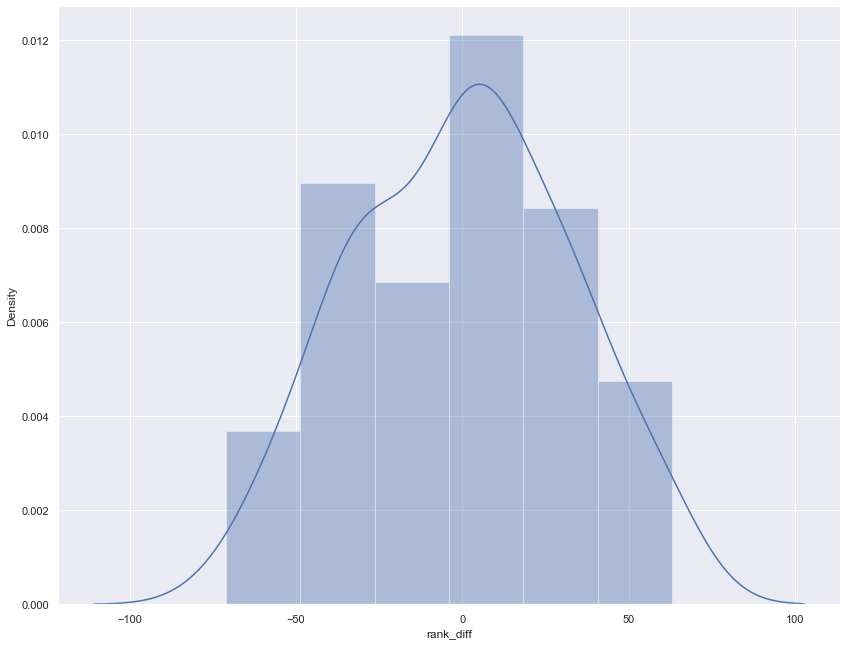

In [533]:
sns.set(rc={'figure.figsize':(14,11)})
sns.distplot(medical_index['rank_diff'])

Выгружаем файл для регрессионого анализа в r-studio.

In [510]:
df.to_csv('medical_index.csv')